<a href="https://www.kaggle.com/code/malshancs/testing-first?scriptVersionId=145598362" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import amp_pd_peptide
import numpy as np
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Read Data

In [2]:
train_proteins = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv")
train_peptides = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv")
train_clinical = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv")

# Creating Master table

In [3]:
protein_grouped = train_proteins.groupby(['visit_id','UniProt'])['NPX'].mean().reset_index()
protein = protein_grouped.pivot(index='visit_id',columns = 'UniProt', values = 'NPX').rename_axis(columns=None).reset_index()

In [4]:
peptide_grouped = train_peptides.groupby(['visit_id','Peptide'])['PeptideAbundance'].mean().reset_index()
peptides = peptide_grouped.pivot(index='visit_id', columns='Peptide', values='PeptideAbundance').rename_axis(columns=None).reset_index()

In [5]:
df1 = protein.merge(peptides, on = ['visit_id'], how = 'left')
# df1

In [6]:
df1 = df1.merge(train_clinical[['visit_id', 'visit_month',"updrs_1", "updrs_2", "updrs_3", "updrs_4"]], how='left', left_on='visit_id', right_on='visit_id')
# df1

In [7]:
train_clinical['is_on_medication'] = train_clinical.apply(lambda row: 1 if row['upd23b_clinical_state_on_medication'] == 'On' else 0, axis=1)
# train_clinical

In [8]:
# add visit_id to df2
df2 = df1.copy()

df1 = df1.merge(train_clinical[['visit_id', 'is_on_medication']], how='left', left_on='visit_id', right_on='visit_id')
df1

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,is_on_medication
0,10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,...,104260.0,530223.0,NaN,7207.30,0.0,3.0,0.0,13.0,0.0,0.0
1,10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,...,123254.0,453883.0,49281.9,25332.80,12.0,4.0,2.0,8.0,0.0,0.0
2,10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,...,128336.0,447505.0,52389.1,21235.70,18.0,2.0,2.0,0.0,0.0,0.0
3,10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,...,129964.0,552232.0,65657.8,9876.98,12.0,3.0,6.0,31.0,0.0,1.0
4,10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,...,111799.0,NaN,56977.6,4903.09,24.0,4.0,7.0,19.0,10.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,8699_24,9983.00,400290.0,24240.10,NaN,16943.50,6303.17,77493.6,46435.3,254247.0,...,133682.0,571879.0,80268.3,54889.70,24.0,11.0,10.0,13.0,2.0,1.0
1109,942_12,6757.32,360858.0,18367.60,14760.7,18603.40,1722.77,86847.4,37741.3,212132.0,...,77976.8,486239.0,45032.7,NaN,12.0,5.0,2.0,25.0,0.0,0.0
1110,942_24,NaN,352722.0,22834.90,23393.1,16693.50,1487.91,114772.0,36095.7,185836.0,...,74483.1,561398.0,52916.4,21847.60,24.0,2.0,3.0,23.0,NaN,0.0
1111,942_48,11627.80,251820.0,22046.50,26360.5,22440.20,2117.43,82241.9,30146.6,167633.0,...,64601.8,632782.0,51123.7,20700.30,48.0,2.0,6.0,35.0,0.0,0.0


In [9]:
df1['peptide_sum'] = df1.iloc[:, 1:228].sum(axis=1)
df1['protein_sum'] = df1.iloc[:, 228:1196].sum(axis=1)
df1['protein_to_peptide_ratio'] = df1['protein_sum'] / df1['peptide_sum']
df1

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YYWGGQYTWDMAK,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,is_on_medication,peptide_sum,protein_sum,protein_to_peptide_ratio
0,10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,...,7207.30,0.0,3.0,0.0,13.0,0.0,0.0,4.713356e+08,4.713352e+08,0.999999
1,10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,...,25332.80,12.0,4.0,2.0,8.0,0.0,0.0,4.666370e+08,4.666371e+08,1.000000
2,10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,...,21235.70,18.0,2.0,2.0,0.0,0.0,0.0,5.220732e+08,5.220732e+08,1.000000
3,10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,...,9876.98,12.0,3.0,6.0,31.0,0.0,1.0,6.515605e+08,6.515605e+08,1.000000
4,10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,...,4903.09,24.0,4.0,7.0,19.0,10.0,1.0,6.720872e+08,6.720870e+08,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,8699_24,9983.00,400290.0,24240.10,NaN,16943.50,6303.17,77493.6,46435.3,254247.0,...,54889.70,24.0,11.0,10.0,13.0,2.0,1.0,6.618367e+08,6.618368e+08,1.000000
1109,942_12,6757.32,360858.0,18367.60,14760.7,18603.40,1722.77,86847.4,37741.3,212132.0,...,NaN,12.0,5.0,2.0,25.0,0.0,0.0,5.540191e+08,5.540194e+08,1.000001
1110,942_24,NaN,352722.0,22834.90,23393.1,16693.50,1487.91,114772.0,36095.7,185836.0,...,21847.60,24.0,2.0,3.0,23.0,NaN,0.0,5.677028e+08,5.677032e+08,1.000001
1111,942_48,11627.80,251820.0,22046.50,26360.5,22440.20,2117.43,82241.9,30146.6,167633.0,...,20700.30,48.0,2.0,6.0,35.0,0.0,0.0,5.979835e+08,5.979831e+08,0.999999


# Handling Missing Values

In [10]:
# Seperate normally distributed columns and skewed columns based on Shapiro test and skewness
from scipy.stats import shapiro, skew

def get_skew_colsss(df):
    p_values = [shapiro(df[col])[1] for col in df.columns]
    skewness = [skew(df[col]) for col in df.columns]

    normal_cols = [i for i, p in zip(df.columns,p_values) if p > 0.5]
    skewed_cols = [i for i,s in zip(df.columns,skewness) if abs(s) > 0.5]

    return normal_cols,skewed_cols

In [11]:
normal_colss = []
skewed_colss = []

normal_colss, skewed_colss = get_skew_colsss(df1.drop(columns=['visit_id','visit_month','is_on_medication','updrs_1','updrs_2','updrs_3','updrs_4']))

In [12]:
len(normal_colss)

1164

In [13]:
len(skewed_colss)

19

In [14]:
all = normal_colss + skewed_colss
rest = [i for i in df1.columns if i not in all]
rest = [i for i in rest if i not in ['visit_id','visit_month','is_on_medication','updrs_1','updrs_2','updrs_3','updrs_4']]
rest

['P01024',
 'P01042',
 'P02647',
 'P02749',
 'P02751',
 'P02765',
 'P02768',
 'P02774',
 'P02790',
 'P05090',
 'P06396',
 'Q12805',
 'peptide_sum',
 'protein_sum',
 'protein_to_peptide_ratio']

In [15]:
# for column in rest:
#     plt.hist(df1[column], bins=10)
#     plt.title(column)
#     plt.show()

### By looking at the distributions we can assume these columns approximately have normal distribution

In [16]:
normal_colss.extend(rest)
# normal_colss

In [17]:
# import sample imputer
from sklearn.impute import SimpleImputer

# create an instance of mean simple imputer
mean_imputer = SimpleImputer(strategy='mean')

# create an instance of median simple imputer
median_imputer = SimpleImputer(strategy='median')

In [18]:
# impute the missing values in the columns in normal_colss with mean
df1[normal_colss] = mean_imputer.fit_transform(df1[normal_colss])

# impute the missing values in the columns in skewed_colss with median
df1[skewed_colss] = median_imputer.fit_transform(df1[skewed_colss])

In [19]:
# Get columns with missing values
missing_cols = df1.columns[df1.isnull().any()].tolist() 
missing_cols 

['visit_month', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 'is_on_medication']

In [20]:
df1_copy = df1.copy()
df1_copy.shape

(1113, 1205)

In [21]:
df1[['visit_id','visit_month','is_on_medication','updrs_1','updrs_2','updrs_3','updrs_4']].isna().sum()

visit_id              0
visit_month          45
is_on_medication     45
updrs_1              45
updrs_2              45
updrs_3              55
updrs_4             544
dtype: int64

In [22]:
# drop rows with missing values in the visit_month column
df1.dropna(subset=['visit_id','visit_month','is_on_medication'], inplace=True)

In [23]:
df1.shape

(1068, 1205)

# Feature selection

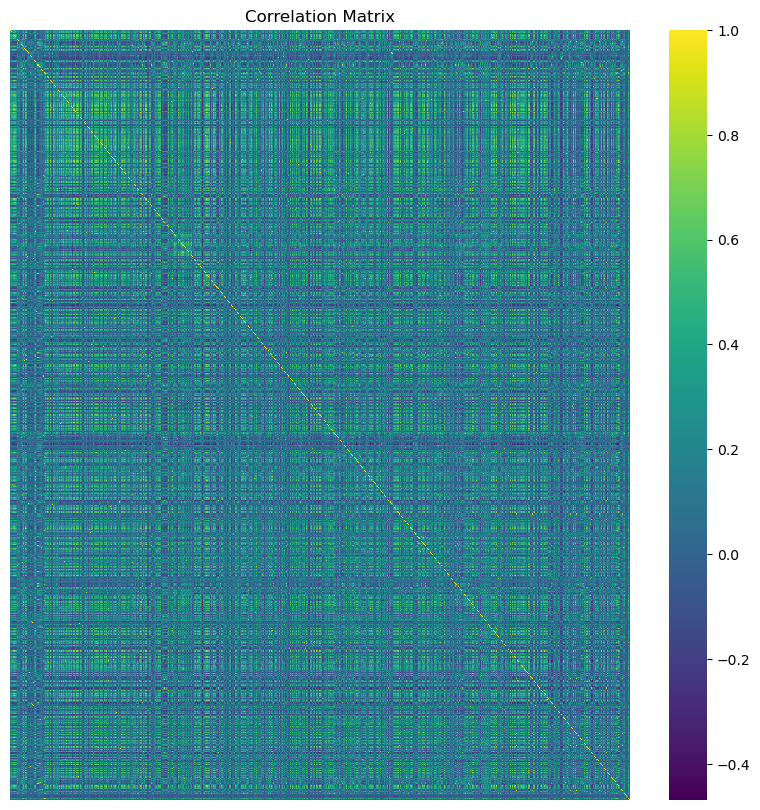

In [24]:
# Compute the correlation matrix
corr_matrix = df1.corr()

# Plot the correlation matrix using Seaborn heatmap
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_matrix, ax=ax, yticklabels=False,xticklabels=False, cmap="viridis")
plt.title("Correlation Matrix")
plt.show()

In [25]:
df2 = df1.copy()

In [26]:
# drop correlated features

# Calculate the correlation matrix
corr_matrix = df1.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than or equal to 0.95
to_drop = [column for column in upper.columns if any(upper[column] >= 0.95)]
to_drop = [column for column in to_drop if column not in ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]]

# Drop highly correlated columns
df1.drop(to_drop, axis=1, inplace=True)

df1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YYTYLIMNK,YYWGGQYTWDMAK,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,is_on_medication,peptide_sum,protein_to_peptide_ratio
0,10053_0,9104.270000,402321.0,26505.529157,27305.934884,7150.570000,2497.840000,83002.9,15113.6,167327.0,...,47068.709311,7207.30000,0.0,3.0,0.0,13.0,0.0,0.0,4.713356e+08,0.999999
1,10053_12,10464.200000,435586.0,26505.529157,27305.934884,17688.295406,3004.990691,197117.0,15099.1,164268.0,...,49281.900000,25332.80000,12.0,4.0,2.0,8.0,0.0,0.0,4.666370e+08,1.000000
2,10053_18,13235.700000,507386.0,7126.960000,24525.700000,17688.295406,2372.710000,126506.0,16289.6,168107.0,...,52389.100000,21235.70000,18.0,2.0,2.0,0.0,0.0,0.0,5.220732e+08,1.000000
3,10138_12,12600.200000,494581.0,9165.060000,27193.500000,22506.100000,6015.900000,156313.0,54546.4,204013.0,...,65657.800000,9876.98000,12.0,3.0,6.0,31.0,0.0,1.0,6.515605e+08,1.000000
4,10138_24,12003.200000,522138.0,4498.510000,17189.800000,29112.400000,2665.150000,151169.0,52338.1,240892.0,...,56977.600000,4903.09000,24.0,4.0,7.0,19.0,10.0,1.0,6.720872e+08,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,8699_24,9983.000000,400290.0,24240.100000,27305.934884,16943.500000,6303.170000,77493.6,46435.3,254247.0,...,80268.300000,54889.70000,24.0,11.0,10.0,13.0,2.0,1.0,6.618367e+08,1.000000
1109,942_12,6757.320000,360858.0,18367.600000,14760.700000,18603.400000,1722.770000,86847.4,37741.3,212132.0,...,45032.700000,21072.04823,12.0,5.0,2.0,25.0,0.0,0.0,5.540191e+08,1.000001
1110,942_24,11641.264435,352722.0,22834.900000,23393.100000,16693.500000,1487.910000,114772.0,36095.7,185836.0,...,52916.400000,21847.60000,24.0,2.0,3.0,23.0,NaN,0.0,5.677028e+08,1.000001
1111,942_48,11627.800000,251820.0,22046.500000,26360.500000,22440.200000,2117.430000,82241.9,30146.6,167633.0,...,51123.700000,20700.30000,48.0,2.0,6.0,35.0,0.0,0.0,5.979835e+08,0.999999


In [27]:
# df1['']

In [28]:
df = df1[['visit_id', 'visit_month', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 'is_on_medication', 'peptide_sum', 'protein_to_peptide_ratio']]
df

,visit_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,is_on_medication,peptide_sum,protein_to_peptide_ratio
0,10053_0,0.0,3.0,0.0,13.0,0.0,0.0,4.713356e+08,0.999999
1,10053_12,12.0,4.0,2.0,8.0,0.0,0.0,4.666370e+08,1.000000
2,10053_18,18.0,2.0,2.0,0.0,0.0,0.0,5.220732e+08,1.000000
3,10138_12,12.0,3.0,6.0,31.0,0.0,1.0,6.515605e+08,1.000000
4,10138_24,24.0,4.0,7.0,19.0,10.0,1.0,6.720872e+08,1.000000
...,...,...,...,...,...,...,...,...,...
1108,8699_24,24.0,11.0,10.0,13.0,2.0,1.0,6.618367e+08,1.000000
1109,942_12,12.0,5.0,2.0,25.0,0.0,0.0,5.540191e+08,1.000001
1110,942_24,24.0,2.0,3.0,23.0,NaN,0.0,5.677028e+08,1.000001
1111,942_48,48.0,2.0,6.0,35.0,0.0,0.0,5.979835e+08,0.999999


In [29]:
df_copy = pd.merge(df, df2[['visit_id', 'protein_sum']], on='visit_id', how='left')
df_copy

,visit_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,is_on_medication,peptide_sum,protein_to_peptide_ratio,protein_sum
0,10053_0,0.0,3.0,0.0,13.0,0.0,0.0,4.713356e+08,0.999999,4.713352e+08
1,10053_12,12.0,4.0,2.0,8.0,0.0,0.0,4.666370e+08,1.000000,4.666371e+08
2,10053_18,18.0,2.0,2.0,0.0,0.0,0.0,5.220732e+08,1.000000,5.220732e+08
3,10138_12,12.0,3.0,6.0,31.0,0.0,1.0,6.515605e+08,1.000000,6.515605e+08
4,10138_24,24.0,4.0,7.0,19.0,10.0,1.0,6.720872e+08,1.000000,6.720870e+08
...,...,...,...,...,...,...,...,...,...,...
1063,8699_24,24.0,11.0,10.0,13.0,2.0,1.0,6.618367e+08,1.000000,6.618368e+08
1064,942_12,12.0,5.0,2.0,25.0,0.0,0.0,5.540191e+08,1.000001,5.540194e+08
1065,942_24,24.0,2.0,3.0,23.0,NaN,0.0,5.677028e+08,1.000001,5.677032e+08
1066,942_48,48.0,2.0,6.0,35.0,0.0,0.0,5.979835e+08,0.999999,5.979831e+08


In [30]:
df = df_copy.copy()

## Create Polynomial Features

In [31]:
# from sklearn.preprocessing import PolynomialFeatures

# # Define the columns for which you want to create polynomial features
# columns = ['is_on_medication','peptide_sum','protein_to_peptide_ratio','protein_sum']

# # Extract the selected columns from the DataFrame
# selected_features = df[columns]

# # Create the polynomial features
# poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
# poly_features = poly_transformer.fit_transform(selected_features)

# # Create a DataFrame with the polynomial features
# poly_df = pd.DataFrame(poly_features, columns=poly_transformer.get_feature_names(columns))

# # Concatenate the original DataFrame with the polynomial features
# df = pd.concat([df, poly_df], axis=1)

# df

In [32]:
# # drop correlated features

# # Calculate the correlation matrix
# corr_matrix = df.corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # Find index of feature columns with correlation greater than or equal to 0.9
# to_drop = [column for column in upper.columns if any(upper[column] >= 0.9)]
# to_drop = [column for column in to_drop if column not in ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]]

# # Drop highly correlated columns
# df.drop(to_drop, axis=1, inplace=True)

# df

In [33]:
if 'updrs_1' in df.columns:
    print("Column 'B' exists in the DataFrame")
else:
    print('Nope')

Column 'B' exists in the DataFrame


In [34]:
# train_clinical

In [35]:
# df.shape

In [36]:
# df = pd.merge(df, train_clinical[['visit_id', 'patient_id']], on='visit_id', how='left')

In [37]:
# df

In [38]:
train = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv")

In [39]:
pro = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv")

In [40]:
pro = pro.pivot(index=['visit_id', 'visit_month', 'patient_id'], 
          columns='UniProt', values='NPX').reset_index().rename_axis(None, axis=1)

In [41]:
pro = pro.dropna(axis=1).drop(columns=['visit_month', 'patient_id'])
print(pro.shape)
pro.head()

(1113, 28)


,visit_id,O15240,P01009,P01011,P01023,P01024,P01042,P01834,P01876,P02647,...,P02790,P05090,P06396,P07602,P10909,P23142,P41222,Q12805,Q92520,Q9UHG2
0,10053_0,83002.9,12825300.0,1084770.0,1005230.0,2669740.0,541909.0,2440800.0,1874270.0,4032650.0,...,3858400.0,4087060.0,1352720.0,731854.0,4749780.0,822784.0,42511700.0,1051980.0,322496.0,177983.0
1,10053_12,197117.0,11871200.0,1135570.0,1230990.0,3360790.0,584371.0,2030500.0,1800070.0,5111760.0,...,3708010.0,3491420.0,1390950.0,618772.0,4223100.0,661058.0,34100500.0,738247.0,496976.0,171733.0
2,10053_18,126506.0,14319900.0,1444430.0,1333940.0,3728860.0,971184.0,2106740.0,1508300.0,5713180.0,...,4773570.0,5096710.0,2232400.0,879126.0,5728010.0,971421.0,38324600.0,843926.0,674551.0,245188.0
3,10138_12,156313.0,11024900.0,1725440.0,1302590.0,4276570.0,1627070.0,4071840.0,5456100.0,22825800.0,...,6629400.0,5233080.0,2535650.0,1204390.0,7528540.0,1246230.0,34148900.0,816347.0,601869.0,229232.0
4,10138_24,151169.0,14145200.0,1544440.0,1221060.0,4570310.0,1301680.0,2421520.0,3032880.0,11136600.0,...,2628690.0,3852520.0,2443370.0,459165.0,8704760.0,1274950.0,45982800.0,598882.0,569973.0,176722.0


In [42]:
merged_df = train.merge(pro, how='left', on='visit_id').dropna(subset=['O15240'])
print(merged_df.shape)
merged_df.head()

(1068, 35)


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,O15240,P01009,...,P02790,P05090,P06396,P07602,P10909,P23142,P41222,Q12805,Q92520,Q9UHG2
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN,177775.0,14415900.0,...,4774060.0,9137820.0,2607410.0,1401860.0,11575700.0,1673460.0,33921600.0,1611130.0,982965.0,408698.0
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN,165638.0,13330800.0,...,5627420.0,8411730.0,2183310.0,1321860.0,10062500.0,1644680.0,34435000.0,1483200.0,860236.0,369870.0
4,55_12,55,12,10.0,10.0,41.0,0.0,On,151073.0,13225500.0,...,5953560.0,8682640.0,2792590.0,1496970.0,10753700.0,1916350.0,37906600.0,1547140.0,969345.0,318553.0
8,55_36,55,36,17.0,18.0,51.0,0.0,On,101056.0,13855000.0,...,6672980.0,9146830.0,2871610.0,1424390.0,11943000.0,1879000.0,32773700.0,1725030.0,910437.0,377550.0
15,942_6,942,6,8.0,2.0,21.0,NaN,NaN,160526.0,13667800.0,...,5755200.0,5415620.0,1636600.0,1090240.0,6855660.0,1085970.0,26674400.0,637932.0,639154.0,306621.0


In [43]:
df1

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YYTYLIMNK,YYWGGQYTWDMAK,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,is_on_medication,peptide_sum,protein_to_peptide_ratio
0,10053_0,9104.270000,402321.0,26505.529157,27305.934884,7150.570000,2497.840000,83002.9,15113.6,167327.0,...,47068.709311,7207.30000,0.0,3.0,0.0,13.0,0.0,0.0,4.713356e+08,0.999999
1,10053_12,10464.200000,435586.0,26505.529157,27305.934884,17688.295406,3004.990691,197117.0,15099.1,164268.0,...,49281.900000,25332.80000,12.0,4.0,2.0,8.0,0.0,0.0,4.666370e+08,1.000000
2,10053_18,13235.700000,507386.0,7126.960000,24525.700000,17688.295406,2372.710000,126506.0,16289.6,168107.0,...,52389.100000,21235.70000,18.0,2.0,2.0,0.0,0.0,0.0,5.220732e+08,1.000000
3,10138_12,12600.200000,494581.0,9165.060000,27193.500000,22506.100000,6015.900000,156313.0,54546.4,204013.0,...,65657.800000,9876.98000,12.0,3.0,6.0,31.0,0.0,1.0,6.515605e+08,1.000000
4,10138_24,12003.200000,522138.0,4498.510000,17189.800000,29112.400000,2665.150000,151169.0,52338.1,240892.0,...,56977.600000,4903.09000,24.0,4.0,7.0,19.0,10.0,1.0,6.720872e+08,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,8699_24,9983.000000,400290.0,24240.100000,27305.934884,16943.500000,6303.170000,77493.6,46435.3,254247.0,...,80268.300000,54889.70000,24.0,11.0,10.0,13.0,2.0,1.0,6.618367e+08,1.000000
1109,942_12,6757.320000,360858.0,18367.600000,14760.700000,18603.400000,1722.770000,86847.4,37741.3,212132.0,...,45032.700000,21072.04823,12.0,5.0,2.0,25.0,0.0,0.0,5.540191e+08,1.000001
1110,942_24,11641.264435,352722.0,22834.900000,23393.100000,16693.500000,1487.910000,114772.0,36095.7,185836.0,...,52916.400000,21847.60000,24.0,2.0,3.0,23.0,NaN,0.0,5.677028e+08,1.000001
1111,942_48,11627.800000,251820.0,22046.500000,26360.500000,22440.200000,2117.430000,82241.9,30146.6,167633.0,...,51123.700000,20700.30000,48.0,2.0,6.0,35.0,0.0,0.0,5.979835e+08,0.999999


In [44]:
FEATURES = [col for col in df.columns if col != 'visit_id' and col not in ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']]
(FEATURES)

['visit_month',
 'is_on_medication',
 'peptide_sum',
 'protein_to_peptide_ratio',
 'protein_sum']

In [45]:
if 'peptide_sum' in FEATURES:
    print("OO")

OO


# Train Model

In [46]:
df

,visit_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,is_on_medication,peptide_sum,protein_to_peptide_ratio,protein_sum
0,10053_0,0.0,3.0,0.0,13.0,0.0,0.0,4.713356e+08,0.999999,4.713352e+08
1,10053_12,12.0,4.0,2.0,8.0,0.0,0.0,4.666370e+08,1.000000,4.666371e+08
2,10053_18,18.0,2.0,2.0,0.0,0.0,0.0,5.220732e+08,1.000000,5.220732e+08
3,10138_12,12.0,3.0,6.0,31.0,0.0,1.0,6.515605e+08,1.000000,6.515605e+08
4,10138_24,24.0,4.0,7.0,19.0,10.0,1.0,6.720872e+08,1.000000,6.720870e+08
...,...,...,...,...,...,...,...,...,...,...
1063,8699_24,24.0,11.0,10.0,13.0,2.0,1.0,6.618367e+08,1.000000,6.618368e+08
1064,942_12,12.0,5.0,2.0,25.0,0.0,0.0,5.540191e+08,1.000001,5.540194e+08
1065,942_24,24.0,2.0,3.0,23.0,NaN,0.0,5.677028e+08,1.000001,5.677032e+08
1066,942_48,48.0,2.0,6.0,35.0,0.0,0.0,5.979835e+08,0.999999,5.979831e+08


In [47]:
# merged_df

In [48]:
# train

In [49]:
# Get columns with missing values
missing_cols = df.columns[df.isnull().any()].tolist() 
missing_cols 

['updrs_3', 'updrs_4']

In [50]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model = {}
mse_dict = {}
mae_dict = {}
r2_dict = {}
smape_dict = {}
target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]

def smape_score(A, F):
    return 100 / len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

for u in target:
    # Drop NAs
    temp = df.dropna(subset=[u])
    
    # Train data
    X = temp[['visit_month', 'is_on_medication', 'peptide_sum', 'protein_to_peptide_ratio', 'protein_sum']]
    y = temp[u]
    
    trained = LinearRegression().fit(X, y)
    
    # Save model
    model[u] = trained

    # Make predictions
    y_pred = trained.predict(X)

    # Calculate evaluation metrics
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    smape = smape_score(y, y_pred)

    # Store metrics in dictionaries
    mse_dict[u] = mse
    mae_dict[u] = mae
    r2_dict[u] = r2
    smape_dict[u] = smape

# Print the evaluation metrics
for u in target:
    print("Evaluation metrics for", u)
    print("MSE:", mse_dict[u])
    print("MAE:", mae_dict[u])
    print("R2 score:", r2_dict[u])
    print("SMAPE score:", smape_dict[u])
    print()


Evaluation metrics for updrs_1
MSE: 25.296126022256423
MAE: 3.8918409962682334
R2 score: 0.10897054297843722
SMAPE score: 67.87589018660053

Evaluation metrics for updrs_2
MSE: 32.52035027411756
MAE: 4.575108968450829
R2 score: 0.07477875011345769
SMAPE score: 96.74792697641041

Evaluation metrics for updrs_3
MSE: 217.60024763686351
MAE: 12.386844448108597
R2 score: 0.0340824327732564
SMAPE score: 88.95600253007551

Evaluation metrics for updrs_4
MSE: 8.611385800634308
MAE: 2.170760862786404
R2 score: 0.08911455655949041
SMAPE score: 149.9914798253966



In [51]:
def smape_score(A, F):
    return 100 / len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

xgb_model = {}
mse_dict = {}
mae_dict = {}
r2_dict = {}
smape_dict = {}
target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]

for u in target:
    # Drop NAs
    temp = df.dropna(subset=[u]).copy()

    # Predict using LinReg
    X = temp[['visit_month', 'is_on_medication', 'peptide_sum', 'protein_to_peptide_ratio', 'protein_sum']]
    temp["preds"] = np.ceil(model[u].predict(X))

    X = temp[FEATURES + ['preds']]
    y = temp[u]

    xgb = XGBRegressor(max_depth=3, learning_rate=0.01, n_estimators=1000, tree_method='gpu_hist')
    xgb.fit(X, y)

    # Save model
    xgb_model[u] = xgb

    # Make predictions
    y_pred = xgb.predict(X)

    # Calculate evaluation metrics
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    smape = smape_score(y, y_pred)

    # Store metrics in dictionaries
    mse_dict[u] = mse
    mae_dict[u] = mae
    r2_dict[u] = r2
    smape_dict[u] = smape

# Print the evaluation metrics
for u in target:
    print("Evaluation metrics for", u)
    print("MSE:", mse_dict[u])
    print("MAE:", mae_dict[u])
    print("R2 score:", r2_dict[u])
    print("SMAPE score:", smape_dict[u])
    print()

Evaluation metrics for updrs_1
MSE: 19.109192552042337
MAE: 3.3686140958736006
R2 score: 0.32689877300635084
SMAPE score: 62.21003270686413

Evaluation metrics for updrs_2
MSE: 24.313032389998742
MAE: 3.9019204832418133
R2 score: 0.3082813061115769
SMAPE score: 91.18434070548197

Evaluation metrics for updrs_3
MSE: 161.8310375050505
MAE: 10.46350872403958
R2 score: 0.2816394110473569
SMAPE score: 83.10474658666134

Evaluation metrics for updrs_4
MSE: 5.790148762521233
MAE: 1.7455261346731852
R2 score: 0.3875361823009741
SMAPE score: 144.9281531775015



# Predict

In [52]:
colss = [col for col in df.columns if col not in ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']]
colss
colsz = [i for i in colss if i not in ['visit_id']]
colsz

['visit_month',
 'is_on_medication',
 'peptide_sum',
 'protein_to_peptide_ratio',
 'protein_sum']

In [53]:
model

{'updrs_1': LinearRegression(),
 'updrs_2': LinearRegression(),
 'updrs_3': LinearRegression(),
 'updrs_4': LinearRegression()}

In [54]:
def get_predictions(my_train, model, xgb_model):

    # Forecast
    my_train = my_train.fillna(0)
    
    for u in target:
        
        # Here is where we will save the final results
        my_train['result_' + str(u)] = 0
        
        # Predict    
        X = my_train[colsz]
        
        #LinReg
        temp = my_train[FEATURES].copy()
        temp['preds'] = np.ceil(model[u].predict(X))
        
        if u != 'updrs_4':
            mask = my_train[FEATURES].sum(axis=1) != 0
            my_train.loc[mask, 'result_' + str(u)] = xgb_model[u].predict(temp.loc[mask])
            my_train.loc[~mask, 'result_' + str(u)] = temp.loc[~mask, 'preds']
    
    # Format for final submission
    result = pd.DataFrame()

    for m in [0, 6, 12, 24]:
        for u in [1, 2, 3, 4]:

            temp = my_train[["visit_id", "result_updrs_" + str(u)]].copy()
            temp["prediction_id"] = temp["visit_id"] + "_updrs_" + str(u) + "_plus_" + str(m) + "_months"
            temp["rating"] = temp["result_updrs_" + str(u)]
            temp = temp [['prediction_id', 'rating']]

            result = result.append(temp)            
    result = result.drop_duplicates(subset=['prediction_id', 'rating'])

    return result

In [55]:
# Run once to check results
get_predictions(df, model, xgb_model).head()

,prediction_id,rating
0,10053_0_updrs_1_plus_0_months,4.729316
1,10053_12_updrs_1_plus_0_months,5.944107
2,10053_18_updrs_1_plus_0_months,4.597407
3,10138_12_updrs_1_plus_0_months,6.685286
4,10138_24_updrs_1_plus_0_months,6.363295


# Default Code to Submit Answers

In [56]:
env = amp_pd_peptide.make_env()   # initialize the environment
iter_test = env.iter_test()  

In [57]:
FEATURES

['visit_month',
 'is_on_medication',
 'peptide_sum',
 'protein_to_peptide_ratio',
 'protein_sum']

In [58]:
for (test, test_peptides, test_proteins, sample_submission) in iter_test:
    
#     test_proteins = test_proteins.pivot(index=['visit_id', 'visit_month', 'patient_id'], 
#           columns='UniProt', values='NPX').reset_index().rename_axis(None, axis=1).drop(columns=['visit_month', 'patient_id'])
    
#     merged_df = test.merge(test_proteins, how='left', on='visit_id')
    peptides_grouped = test_peptides.groupby(['visit_id','Peptide'])['PeptideAbundance'].mean().reset_index()
    peptidess = peptides_grouped.pivot(index='visit_id', columns='Peptide', values='PeptideAbundance').rename_axis(columns=None).reset_index()
    
    proteins_grouped = test_proteins.groupby(['visit_id','UniProt'])['NPX'].mean().reset_index()
    proteins = proteins_grouped.pivot(index='visit_id',columns = 'UniProt', values = 'NPX').rename_axis(columns=None).reset_index()
    
    df11 = proteins.merge(peptidess, on = ['visit_id'], how = 'left')
    
    df11['peptide_sum'] = df11.iloc[:, 1:228].sum(axis=1)
    df11['protein_sum'] = df11.iloc[:, 228:1196].sum(axis=1)
    df11['protein_to_peptide_ratio'] = df11['protein_sum'] / df1['peptide_sum']
    
    df11 = df11[['visit_id','peptide_sum', 'protein_to_peptide_ratio','protein_sum']]
    
    merged_df = test.merge(df11, how='left', on='visit_id')
    print(merged_df)
    
    for col in FEATURES:
        if col not in merged_df.columns:
            merged_df[col] = 0
    
#     merged_df = merged_df[['visit_id', 'visit_month'] + FEATURES]
    
    merged_df[FEATURES] = merged_df[FEATURES].fillna(0)
    print(sample_submission)
    print("=======================================================================================")
    result = get_predictions(merged_df, model, xgb_model)
    
#     print(result)

    env.predict(result)   #register your predictions#

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
  visit_id  visit_month  patient_id updrs_test           row_id   peptide_sum  \
0   3342_0            0        3342    updrs_1   3342_0_updrs_1           NaN   
1   3342_0            0        3342    updrs_2   3342_0_updrs_2           NaN   
2   3342_0            0        3342    updrs_3   3342_0_updrs_3           NaN   
3   3342_0            0        3342    updrs_4   3342_0_updrs_4           NaN   
4  50423_0            0       50423    updrs_1  50423_0_updrs_1  7.402406e+08   
5  50423_0            0       50423    updrs_2  50423_0_updrs_2  7.402406e+08   
6  50423_0            0       50423    updrs_3  50423_0_updrs_3  7.402406e+08   
7  50423_0            0       50423    updrs_4  50423_0_updrs_4  7.402406e+08   

   protein_to_peptide_ratio   protein_sum  
0                       NaN           NaN  
1                       NaN           NaN  
2            